In [1]:
import torch
import wandb
import sys
from configmypy import ConfigPipeline, YamlConfig, ArgparseConfig
from neuralop import get_model
from neuralop import Trainer
from neuralop.training import setup
from neuralop.datasets import load_darcy_pt
from neuralop.utils import get_wandb_api_key, count_params
from neuralop import LpLoss, H1Loss

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


# Loading the configuration

You can open the yaml file in config/darcy_config in the same folder as this notebook to inspect the parameters and change them.

In [2]:
# Read the configuration
config_name = 'default'
pipe = ConfigPipeline([YamlConfig('./darcy_config.yaml', config_name='default', config_folder='./config'),
                      ])
config = pipe.read_conf()
config_name = pipe.steps[-1].config_name

## Setup

Here we just setup pytorch and print the configuration

In [3]:
# Set-up distributed communication, if using
device, is_logger = setup(config)

In [4]:
# Make sure we only print information when needed
config.verbose = config.verbose and is_logger

#Print config to screen
if config.verbose and is_logger:
    pipe.log()
    sys.stdout.flush()

###############################
#####    CONFIGURATION    #####
###############################

Steps:
------
 (1) YamlConfig with config_file=./darcy_config.yaml, config_name=default, config_folder=./config

-------------------------------

Configuration:
--------------

verbose=True
arch=tfno2d
distributed.use_distributed=False
tfno2d.data_channels=3
tfno2d.n_modes_height=64
tfno2d.n_modes_width=64
tfno2d.hidden_channels=64
tfno2d.projection_channels=256
tfno2d.n_layers=4
tfno2d.domain_padding=None
tfno2d.domain_padding_mode=one-sided
tfno2d.fft_norm=forward
tfno2d.norm=group_norm
tfno2d.skip=linear
tfno2d.implementation=factorized
tfno2d.separable=0
tfno2d.preactivation=0
tfno2d.use_mlp=1
tfno2d.mlp.expansion=0.5
tfno2d.mlp.dropout=0
tfno2d.factorization=None
tfno2d.rank=1.0
tfno2d.fixed_rank_modes=None
tfno2d.dropout=0.0
tfno2d.tensor_lasso_penalty=0.0
tfno2d.joint_factorization=False
opt.n_epochs=100
opt.learning_rate=0.005
opt.training_loss=h1
opt.weight_decay=0.0001
opt.amp_aut

# Loading the data 

We train in one resolution and test in several resolutions to show the zero-shot super-resolution capabilities of neural-operators. 

In [5]:
import numpy as np
from neuralop.utils import UnitGaussianNormalizer
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.transforms import Normalizer, PositionalEmbedding, MGPTensorDataset
data = np.load('/dli/task/bootcamp/data/kf/KFvorticity_Re100_N50_T500.npy')

ns_input = data[:, 0:500, :, :] # define the input as [50, 0:500, 64, 64]
ns_output = data[:, 1:501, :, :] # define the output one-frame off [50, 1:501, 64, 64]
grid_boundaries=[[0,1],[0,1]]
batch_size=config.data.batch_size
test_batch_size=config.data.test_batch_sizes.pop(0)
num_workers = 2
pin_memory=True
persistent_workers=True
train_resolution=config.data.train_resolution
test_resolutions=config.data.test_resolutions
n_tests=config.data.n_tests

n_train=config.data.n_train
positional_encoding=config.data.positional_encoding
test_batch_sizes=config.data.test_batch_sizes


x_train = torch.zeros(40*500, 64, 64) # training input
for i in range(40):
    for j in range(500):
        x_train[500*i+j, :, :] = torch.Tensor(ns_input[i, j, :, :])
        # mix the trajectory index and the time index to convert the time series into an image-to-image mapping
x_train = x_train.unsqueeze(1).clone()

y_train = torch.zeros(40*500, 64, 64) # training output
for i in range(40):
    for j in range(500):
        y_train[500*i+j, :, :] = torch.Tensor(ns_output[i, j, :, :])
        # mix the trajectory index and the time index to convert the time series into an image-to-image mapping
y_train = y_train.unsqueeze(1).clone()

x_test = torch.zeros(10*500, 64, 64) # testing input
for i in range(40, 50):
    for j in range(500):
        x_test[500*(i-40)+j, :, :] = torch.Tensor(ns_input[i, j, :, :])
        # mix the trajectory index and the time index to convert the time series into an image-to-image mapping
x_test = x_test.unsqueeze(1).clone()

y_test = torch.zeros(10*500, 64, 64) # testing output
for i in range(40, 50):
    for j in range(500):
        y_test[500*(i-40)+j, :, :] = torch.Tensor(ns_output[i, j, :, :])
        # mix the trajectory index and the time index to convert the time series into an image-to-image mapping
y_test = y_test.unsqueeze(1).clone()

'''
# Original data shape is (50, 501, 64, 64)
# ns_input = ns_output shape is (50, 500, 64, 64),
# then convert the time series into an image-to-image mapping of (50*500, 64, 64)
# here, x_train.shape = y_train.shape = torch.Size([20000, 1, 64, 64]),
# x_test.shape = y_test.shape = torch.Size([5000, 1, 64, 64])
'''

reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(x_train, reduce_dim=reduce_dims)
x_train = input_encoder.encode(x_train)
x_test = input_encoder.encode(x_test.contiguous())

reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(y_train, reduce_dim=reduce_dims)
y_train = output_encoder.encode(y_train)

train_db = TensorDataset(x_train, y_train, transform_x=PositionalEmbedding(grid_boundaries, 0))
train_loader = torch.utils.data.DataLoader(train_db,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=num_workers, pin_memory=pin_memory, persistent_workers=persistent_workers)

test_db = TensorDataset(x_test, y_test,transform_x=PositionalEmbedding(grid_boundaries, 0))
test_loader = torch.utils.data.DataLoader(test_db,
                                          batch_size=test_batch_size, shuffle=False,
                                          num_workers=num_workers, pin_memory=pin_memory, persistent_workers=persistent_workers)

test_loaders =  {train_resolution: test_loader}

'''
# 经过DataLoader后x_train, x_test均被拆为多个torch.Size([64, 3, 64, 64])
# 经过Encoder处理后归一化，此后plot需要decode
'''

UnitGaussianNormalizer init on 20000, reducing over [0, 1, 2, 3], samples of shape [1, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
UnitGaussianNormalizer init on 20000, reducing over [0, 1, 2, 3], samples of shape [1, 64, 64].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05


'\n# 经过DataLoader后x_train, x_test均被拆为多个torch.Size([64, 3, 64, 64])\n# 经过Encoder处理后归一化，此后plot需要decode\n'

# Creating the model and putting it on the GPU 

In [6]:
model = get_model(config)
model = model.to(device)

#Log parameter count
if is_logger:
    n_params = count_params(model)

    if config.verbose:
        print(f'\nn_params: {n_params}')
        sys.stdout.flush()

Given argument key='dropout' that is not in TFNO2d's signature.
Given argument key='tensor_lasso_penalty' that is not in TFNO2d's signature.
Keyword argument out_channels not specified for model TFNO2d, using default=1.
Keyword argument lifting_channels not specified for model TFNO2d, using default=256.
Keyword argument non_linearity not specified for model TFNO2d, using default=<built-in function gelu>.
Keyword argument decomposition_kwargs not specified for model TFNO2d, using default={}.

n_params: 67176321


# Create the optimizer and learning rate scheduler

Here, we use an Adam optimizer and a learning rate schedule depending on the configuration

In [7]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=config.opt.learning_rate, 
                                weight_decay=config.opt.weight_decay)

if config.opt.scheduler == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.opt.gamma, patience=config.opt.scheduler_patience, mode='min')
elif config.opt.scheduler == 'CosineAnnealingLR':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.opt.scheduler_T_max)
elif config.opt.scheduler == 'StepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                step_size=config.opt.step_size,
                                                gamma=config.opt.gamma)
else:
    raise ValueError(f'Got {config.opt.scheduler=}')

# Creating the loss

We will optimize the Sobolev norm but also evaluate our goal: the l2 relative error

In [8]:
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
if config.opt.training_loss == 'l2':
    train_loss = l2loss
elif config.opt.training_loss == 'h1':
    train_loss = h1loss
else:
    raise ValueError(f'Got training_loss={config.opt.training_loss} but expected one of ["l2", "h1"]')
eval_losses={'h1': h1loss, 'l2': l2loss}

In [9]:
if config.verbose and is_logger:
    print('\n### MODEL ###\n', model)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    print(f'\n### Beginning Training...\n')
    sys.stdout.flush()


### MODEL ###
 TFNO2d(
  (convs): FactorizedSpectralConv2d(
    (weight): ModuleList(
      (0): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (1): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (2): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (3): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (4): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (5): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (6): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
      (7): ComplexDenseTensor(shape=torch.Size([64, 64, 32, 32]), rank=None)
    )
  )
  (fno_skips): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), str

# Creating the trainer

In [10]:
trainer = Trainer(model, n_epochs=config.opt.n_epochs,
                  device=device,
                  mg_patching_levels=config.patching.levels,
                  mg_patching_padding=config.patching.padding,
                  mg_patching_stitching=config.patching.stitching,
                  wandb_log=config.wandb.log,
                  log_test_interval=config.wandb.log_test_interval,
                  log_output=False,
                  use_distributed=config.distributed.use_distributed,
                  verbose=config.verbose and is_logger)

Training on regular inputs (no multi-grid patching).


# Training the model 

In [11]:
trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 20000 samples
Testing on [5000] samples         on resolutions [64].
[0] time=53.23, avg_loss=136.1071, train_err=0.6805, 64_h1=0.5610, 64_l2=0.3870
[1] time=45.10, avg_loss=96.1890, train_err=0.4809, 64_h1=0.4205, 64_l2=0.2698
[2] time=45.14, avg_loss=80.0721, train_err=0.4004, 64_h1=0.4132, 64_l2=0.2572
[3] time=45.10, avg_loss=70.1563, train_err=0.3508, 64_h1=0.3441, 64_l2=0.2158
[4] time=45.09, avg_loss=63.3168, train_err=0.3166, 64_h1=0.3297, 64_l2=0.2157
[5] time=45.14, avg_loss=58.9172, train_err=0.2946, 64_h1=0.3022, 64_l2=0.2014
[6] time=45.10, avg_loss=55.5584, train_err=0.2778, 64_h1=0.2858, 64_l2=0.1796
[7] time=45.09, avg_loss=52.7037, train_err=0.2635, 64_h1=0.2658, 64_l2=0.1684
[8] time=45.14, avg_loss=50.2851, train_err=0.2514, 64_h1=0.2593, 64_l2=0.1611
[9] time=45.11, avg_loss=47.5080, train_err=0.2375, 64_h1=0.2700, 64_l2=0.1665
[10] time=45.08, avg_loss=47.3037, train_err=0.2365, 64_h1=0.2588, 64_l2=0.1634
[11] time=45.14, avg_loss=44.7252, train_err=0.2

# Follow-up questions

You can now play with the configuration and see how the performance is impacted.

Which parameters do you think will most influence performance? 
Learning rate? Learning schedule? hidden_channels? Number of training samples? 

Does your intuition match the results you are getting?

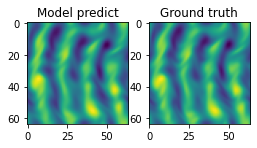

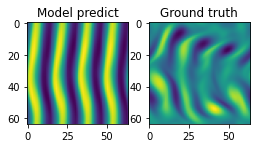

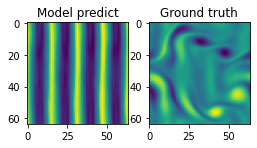

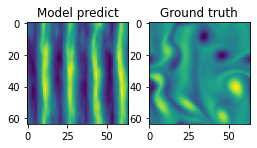

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
for sample in test_loader:
    x, y = sample['x'], sample['y']
    x_recurrent = x[:,-3:]
    for i in range(4):
        out = model(x_recurrent[:,-3:].to(device))
        out = output_encoder.decode(out)
        out = out.cpu()
        y = output_encoder.decode(y.to(device))
        y = y.cpu()
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(out[0][0].detach().numpy())
        ax.set_title('Model predict')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(y[0+i][0].detach().numpy())
        ax.set_title('Ground truth')
        x_recurrent = torch.cat((x_recurrent, out), 1)
    break

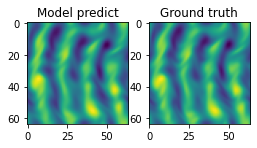

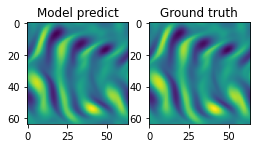

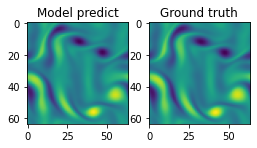

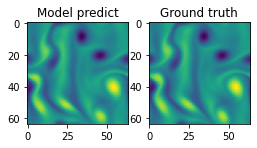

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
for sample in test_loader:
    x, y = sample['x'], sample['y']
    out = model(x.to(device))
    out = output_encoder.decode(out)
    out = out.cpu()
    y = output_encoder.decode(y.to(device))
    y = y.cpu()
    for i in range(4):
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(out[0+i][0].detach().numpy())
        ax.set_title('Model predict')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(y[0+i][0].detach().numpy())
        ax.set_title('Ground truth')
    break